In [0]:
import numpy as np
import csv
from tqdm import tqdm
from sklearn.utils import shuffle
import nltk
import re
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM, Reshape, Dropout, Flatten
from keras import regularizers 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import   

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#declare path
path_to_project = '/content/gdrive/My Drive/ESTR project AI/OLIDv1.0/'
path_to_data = path_to_project + 'olid-training-v1.0.tsv'

In [0]:
#0 - Not offensive
#1 - Offensive untargeted
#2 - Offensive targeted indiviualds
#3 - Offensive targeted groups 
#4 - Offensive targeted others
def get_label(labels):
  answer = 0
  if labels[1] == 'UNT':
    answer = 1
  if labels[2] == 'IND':
    answer = 2
  if labels[2] == 'GRP':
    answer = 3
  if labels[2] == 'OTH':
    answer = 4
  return answer

def convert(label, sub_task):
  if sub_task == 'a':
    return int(label > 0)
  if sub_task == 'b':
    return int(label > 1)
  return label - 2

def prepare_data(path,sub_task):
  data=[]
  labels=[]
  with open(path,encoding='utf8') as file:
    for i,line in enumerate(csv.reader(file,delimiter='\t')):
      if i == 0:
        continue
      x = get_label(line[-3:])
      if x > 0:
        data.append(line[1])
        labels.append(convert(x,sub_task))
  return data,labels  

def get_test_label(label,sub_task):
  answer = 0
  if sub_task == 'a':
    if label == 'OFF':
      answer = 1
  if sub_task == 'b':
    if label == 'TIN':
      answer = 1
  if sub_task == 'c':
    if label == 'GRP':
      answer = 1
    if label == 'OTH':
      answer = 2
  return answer
def get_test_data(sub_task):
  data=[]
  labels=[]
  path_labels = path_to_project + 'labels-level' + sub_task + '.csv'
  path_data = path_to_project + 'testset-level' + sub_task + '.tsv'
  with open(path_data,encoding='utf8') as file:
    for i,line in enumerate(csv.reader(file,delimiter='\t')):
      if i == 0:
        continue
      data.append(line[1])
  with open(path_labels,encoding='utf8') as file:
    for line in csv.reader(file):
      labels.append(get_test_label(line[1],sub_task))
      #labels.append(line[1])
  return data,labels

In [5]:
#preprocessing dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#preprocessing
def tokenize(data):
  answer = []
  for text in data:
    answer.append(nltk.word_tokenize(text.lower()))
  return answer

def stop_words(data):
  answer = []
  bad_words = set(nltk.corpus.stopwords.words('english'))
  for text in data:
    answer.append([x for x in text if not x in bad_words and not re.match(r"[^a-zA-Z\d\s]+", x) and x != 'user'])
  return answer

def get_tag(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
  return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)
  
def lemmatize(data):
  answer = []      
  lemmatizer = nltk.stem.WordNetLemmatizer()
  for text in data:
    answer.append([lemmatizer.lemmatize(x, pos=get_tag(x)) for x in text])
  return answer
  
#Vectorization
def count_vectorizer_len(data):
  vectorizer = CountVectorizer()
  converted_data = [' '.join(x) for x in data]
  vectorizer.fit(converted_data)
  return len(vectorizer.vocabulary_.keys())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
#preparing data to be compatibel with Neural networks
def do_one_hot(data):
  encoder = OneHotEncoder();
  return encoder.fit_transform(np.array(data).reshape(-1,1)).toarray()
def do_input_proc(data, len, longest_seq):
  converted_data = [keras.preprocessing.text.one_hot(' '.join(x), len) for x in data]
  return keras.preprocessing.sequence.pad_sequences(converted_data, maxlen=longest_seq, padding='post')
def get_max_len(data):
  answer = 0
  for x in data:
    answer = max(answer, len(x))
  return answer

In [0]:
def plot_confusion(data, labels, model, classes=2):
  predicted_labels = model.predict(data, batch_size=64)
  mtx = np.zeros(shape=(classes,classes))
  for i in range(0,len(predicted_labels)):
    actual_label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])
    mtx[actual_label,predicted_label] += 1
  plt.imshow(mtx,cmap=plt.cm.ocean_r)
  plt.title('Confusion matrix')
  plt.colorbar()
  marks = [x for x in ['UNT', 'TIN']]
  plt.xlabel('Predicted Label')
  plt.xticks(np.arange(classes), marks)
  plt.ylabel('True Label')
  plt.yticks(np.arange(classes), marks)
  plt.tight_layout()
  for (i, j), z in np.ndenumerate(mtx):
    plt.text(j, i, int(z), ha='center', va='center')
  plt.show()
def do_analysis(test_data, test_labels, model):
  predicted_labels = model.predict(test_data, batch_size=64)
  y_true = np.argmax(test_labels, axis = 1)
  y_pred = np.argmax(predicted_labels, axis = 1)
  print(classification_report(y_true, y_pred))
  plot_confusion(test_data, test_labels, model, 2)

In [44]:
data,labels = prepare_data(path_to_data,'b')
test_data,test_labels = get_test_data('b')
data = lemmatize(stop_words(tokenize(data)))
test_data = lemmatize(stop_words(tokenize(test_data)))
vocab_length = count_vectorizer_len(data)
longest_seq = max(get_max_len(data),get_max_len(test_data))
#convert data to work with NN
train_data, val_data, train_labels, val_labels = train_test_split(np.array(data),labels, test_size=0.35,stratify=labels)
train_labels = do_one_hot(train_labels)
val_labels = do_one_hot(val_labels)
test_labels = do_one_hot(test_labels)
train_data = do_input_proc(train_data, vocab_length, longest_seq)
val_data = do_input_proc(val_data, vocab_length, longest_seq)
test_data = do_input_proc(test_data, vocab_length, longest_seq)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [96]:
data,labels = prepare_data(path_to_data,'b')
test_data,test_labels = get_test_data('b')
data = lemmatize(stop_words(tokenize(data)))
test_data = lemmatize(stop_words(tokenize(test_data)))
vocab_length = count_vectorizer_len(data)
longest_seq = max(get_max_len(data),get_max_len(test_data))
#convert data to work with NN
#train_data, val_data, train_labels, val_labels = train_test_split(np.array(data),labels, test_size=0.35,stratify=labels)
train_labels = do_one_hot(labels)
test_labels = do_one_hot(test_labels)
train_data = do_input_proc(data, vocab_length, longest_seq)
test_data = do_input_proc(test_data, vocab_length, longest_seq)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
labels[:100]

In [133]:
lstm = Sequential()
lstm.add(Embedding(vocab_length, 30, input_length=longest_seq))
lstm.add(LSTM(200))
lstm.add(Dense(longest_seq, activation='relu', W_regularizer=regularizers.l2(0.90)))
lstm.add(Dense(train_labels.shape[1], activation='sigmoid', W_regularizer=regularizers.l2(0.1)))
adam_1 = Adam(lr=0.008)
lstm.compile(loss='binary_crossentropy', optimizer=adam_1,metrics=['accuracy'])
lstm.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 41, 30)            253230    
_________________________________________________________________
lstm_16 (LSTM)               (None, 200)               184800    
_________________________________________________________________
dense_35 (Dense)             (None, 41)                8241      
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 84        
Total params: 446,355
Trainable params: 446,355
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(41, activation="relu", kernel_regularizer=<keras.reg...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="sigmoid", kernel_regularizer=<keras.reg...)`
  """


In [0]:
class_weights = class_weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)

In [135]:
class_weights

array([4.19847328, 0.56759546])

In [137]:
lstm.fit(train_data, train_labels, batch_size=64,epochs=30,verbose=1,validation_data=(test_data,test_labels),class_weight=class_weights)

Train on 4400 samples, validate on 240 samples
Epoch 1/30
3520/4400 [=======================>......] - ETA: 0s - loss: 0.3718 - acc: 0.8810

KeyboardInterrupt: ignored

In [89]:
print(lstm.metrics_names, lstm.evaluate(test_data, test_labels, batch_size=64, verbose=1))

240/240 [==============================] - 0s 410us/step
['loss', 'acc'] [0.3542595148086548, 0.8875]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.89      1.00      0.94       213

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240

[[0. 1.]
 [0. 1.]]


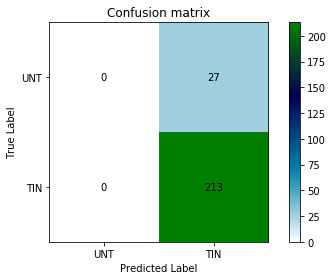

In [100]:
do_analysis(test_data, test_labels, lstm)

In [147]:
# lstm model
lstm1 = Sequential()
lstm1.add(Embedding(vocab_length, 30, input_length=longest_seq))
lstm1.add(Dropout(0.5))
lstm1.add(LSTM(100))
#lstm.add(Dense(longest_seq, activation='relu', W_regularizer=regularizers.l2(0.90))) , W_regularizer=regularizers.l2(0.1))
lstm1.add(Dense(train_labels.shape[1], activation='softmax'))
madam = Adam(lr=0.008)
lstm1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
lstm1.summary()
early_stopping = EarlyStopping(monitor='loss', patience=5)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 41, 30)            253230    
_________________________________________________________________
dropout_36 (Dropout)         (None, 41, 30)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               52400     
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 202       
Total params: 305,832
Trainable params: 305,832
Non-trainable params: 0
_________________________________________________________________


In [148]:
lstm1.fit(train_data, train_labels, batch_size=16,epochs=15,verbose=1,validation_data=(test_data,test_labels),class_weight=class_weights)

Train on 4400 samples, validate on 240 samples
Epoch 1/15
4400/4400 [==============================] - 22s 5ms/step - loss: 0.3806 - acc: 0.8809 - val_loss: 0.3550 - val_acc: 0.8875
Epoch 2/15
4400/4400 [==============================] - 17s 4ms/step - loss: 0.3674 - acc: 0.8809 - val_loss: 0.3532 - val_acc: 0.8875
Epoch 3/15
4400/4400 [==============================] - 17s 4ms/step - loss: 0.3677 - acc: 0.8809 - val_loss: 0.3522 - val_acc: 0.8875
Epoch 4/15
4400/4400 [==============================] - 17s 4ms/step - loss: 0.3657 - acc: 0.8809 - val_loss: 0.3535 - val_acc: 0.8875
Epoch 5/15
4400/4400 [==============================] - 17s 4ms/step - loss: 0.3674 - acc: 0.8809 - val_loss: 0.3543 - val_acc: 0.8875
Epoch 6/15
4400/4400 [==============================] - 17s 4ms/step - loss: 0.3526 - acc: 0.8809 - val_loss: 0.3350 - val_acc: 0.8875
Epoch 7/15
4400/4400 [==============================] - 17s 4ms/step - loss: 0.3355 - acc: 0.8805 - val_loss: 0.3247 - val_acc: 0.8875
Epoch 8/

In [149]:
print(lstm1.metrics_names, lstm1.evaluate(test_data, test_labels, batch_size=64, verbose=1))

240/240 [==============================] - 0s 450us/step
['loss', 'acc'] [0.45433543920516967, 0.837499996026357]


In [0]:
def plot_norm(data, labels, model, classes=2):
  predicted_labels = model.predict(data, batch_size=64)
  mtx = np.zeros(shape=(classes,classes))
  for i in range(0,len(predicted_labels)):
    actual_label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])
    mtx[actual_label,predicted_label] += 1
  norm = np.zeros(shape=(classes,classes))
  for i in range(classes):
    for j in range(classes):
      norm[i][j] = mtx[i][j] / np.sum(mtx[i])
  print(norm)
  plt.imshow(norm,cmap=plt.cm.ocean_r)
  plt.title('Confusion matrix')
  plt.colorbar()
  marks = [x for x in ['UNT', 'TIN']]
  plt.xlabel('Predicted Label')
  plt.xticks(np.arange(classes), marks)
  plt.ylabel('True Label')
  plt.yticks(np.arange(classes), marks)
  plt.tight_layout()
  for (i, j), z in np.ndenumerate(norm):
    plt.text(j, i, round(z,2), ha='center', va='center')
  plt.show()

[[0.22222222 0.77777778]
 [0.08450704 0.91549296]]


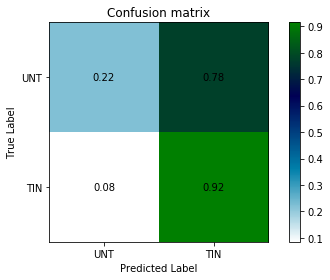

In [159]:
plot_norm(test_data, test_labels, lstm1)

              precision    recall  f1-score   support

           0       0.25      0.22      0.24        27
           1       0.90      0.92      0.91       213

    accuracy                           0.84       240
   macro avg       0.58      0.57      0.57       240
weighted avg       0.83      0.84      0.83       240

[[0.22222222 0.77777778]
 [0.08450704 0.91549296]]


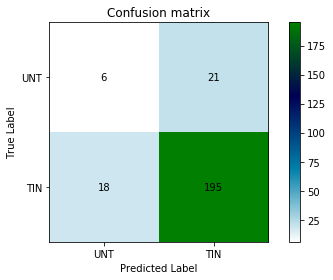

In [150]:
do_analysis(test_data, test_labels, lstm1)


In [53]:
# lstm model
lstm_complex = Sequential()
lstm_complex.add(Embedding(vocab_length, 30, input_length=longest_seq))
#lstm_complex.add(Dropout(0.4))
lstm_complex.add(LSTM(50))
lstm_complex.add(Dense(longest_seq, activation='relu'))
lstm_complex.add(Dropout(0.75))
lstm_complex.add(Dense(train_labels.shape[1], activation='sigmoid'))
#madam = Adam(lr=0.008)
lstm_complex.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
lstm_complex.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 30)            253230    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dense_12 (Dense)             (None, 41)                2091      
_________________________________________________________________
dropout_7 (Dropout)          (None, 41)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 84        
Total params: 271,605
Trainable params: 271,605
Non-trainable params: 0
_________________________________________________________________


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
lstm_complex.fit(train_data, train_labels, batch_size=64,epochs=8,verbose=1,validation_data=(val_data,val_labels),callbacks=[early_stopping])

Train on 2860 samples, validate on 1540 samples
Epoch 1/8
2860/2860 [==============================] - 5s 2ms/step - loss: 0.5141 - acc: 0.8762 - val_loss: 0.3807 - val_acc: 0.8812
Epoch 2/8
2860/2860 [==============================] - 3s 1ms/step - loss: 0.4126 - acc: 0.8808 - val_loss: 0.3649 - val_acc: 0.8812
Epoch 3/8
2860/2860 [==============================] - 3s 1ms/step - loss: 0.4038 - acc: 0.8808 - val_loss: 0.3657 - val_acc: 0.8812
Epoch 4/8
2860/2860 [==============================] - 3s 1ms/step - loss: 0.4040 - acc: 0.8808 - val_loss: 0.3653 - val_acc: 0.8812


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.89      1.00      0.94       213

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240

[[0. 1.]
 [0. 1.]]


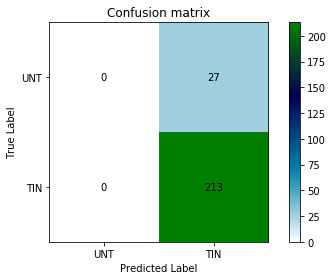

In [56]:
do_analysis(test_data, test_labels, lstm_complex)

In [125]:
cnn = Sequential()
cnn.add(Embedding(vocab_length, 30, input_length=longest_seq))
cnn.add(Reshape((30,longest_seq,1)))
cnn.add(Convolution2D(32,(1,5),activation="relu"))
cnn.add(Dropout(0.9))
cnn.add(Convolution2D(16,(2,3),activation="relu"))
cnn.add(Dropout(0.8))
cnn.add(Convolution2D(16,(2,2),activation="relu"))
cnn.add(Dropout(0.7))
cnn.add(Flatten())
cnn.add(Dense(train_labels.shape[1],activation='sigmoid'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 41, 30)            253230    
_________________________________________________________________
reshape_9 (Reshape)          (None, 30, 41, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 37, 32)        192       
_________________________________________________________________
dropout_30 (Dropout)         (None, 30, 37, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 35, 16)        3088      
_________________________________________________________________
dropout_31 (Dropout)         (None, 29, 35, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 34, 16)      

In [126]:
early_stopping = EarlyStopping(monitor='val_acc', patience=10)
cnn.fit(train_data, train_labels, batch_size=64,epochs=6,verbose=1,validation_data=(test_data,test_labels),callbacks=[early_stopping],class_weight=class_weights)

Train on 4400 samples, validate on 240 samples
Epoch 1/6
4400/4400 [==============================] - 4s 936us/step - loss: 0.3865 - acc: 0.8741 - val_loss: 0.5188 - val_acc: 0.8875
Epoch 2/6
4400/4400 [==============================] - 0s 97us/step - loss: 0.3609 - acc: 0.8809 - val_loss: 0.5573 - val_acc: 0.8875
Epoch 3/6
4400/4400 [==============================] - 0s 105us/step - loss: 0.3531 - acc: 0.8809 - val_loss: 0.5162 - val_acc: 0.8875
Epoch 4/6
4400/4400 [==============================] - 0s 97us/step - loss: 0.3262 - acc: 0.8809 - val_loss: 0.5498 - val_acc: 0.8875
Epoch 5/6
4400/4400 [==============================] - 0s 110us/step - loss: 0.2769 - acc: 0.8809 - val_loss: 0.3984 - val_acc: 0.8875
Epoch 6/6
4400/4400 [==============================] - 0s 98us/step - loss: 0.2207 - acc: 0.8945 - val_loss: 0.3574 - val_acc: 0.8583


              precision    recall  f1-score   support

           0       0.29      0.19      0.23        27
           1       0.90      0.94      0.92       213

    accuracy                           0.86       240
   macro avg       0.60      0.56      0.57       240
weighted avg       0.83      0.86      0.84       240

[[0.18518519 0.81481481]
 [0.05633803 0.94366197]]


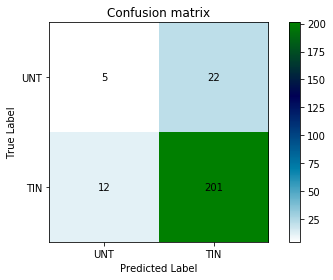

In [128]:
do_analysis(test_data, test_labels, cnn)